In [2]:
import librosa
import numpy as np
import os
import math
from sklearn.cluster import KMeans
import hmmlearn.hmm
from time import time
from sklearn.model_selection import train_test_split
from collections import defaultdict
from sklearn.model_selection import LeaveOneOut
from tqdm import tqdm
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import random
from sklearn.metrics import log_loss
from scipy.special import softmax
from sklearn.metrics import confusion_matrix
np.set_printoptions(precision=4)

c:\users\84965\appdata\local\continuum\anaconda3\envs\voiceclass\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
c:\users\84965\appdata\local\continuum\anaconda3\envs\voiceclass\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


# Function

In [5]:
def get_mfcc(file_path):
    y, sr = librosa.load(file_path) # read .wav file
    hop_length = math.floor(sr*0.010) # 10ms hop
    win_length = math.floor(sr*0.025) # 25ms frame
    # mfcc is 12 x T matrix
    mfcc = librosa.feature.mfcc(
        y, sr, n_mfcc=12, n_fft=1024,
        hop_length=hop_length, win_length=win_length)
    # substract mean from mfcc --> normalize mfcc
    mfcc = mfcc - np.mean(mfcc, axis=1).reshape((-1,1)) 
    # delta feature 1st order and 2nd order
    delta1 = librosa.feature.delta(mfcc, order=1)
    delta2 = librosa.feature.delta(mfcc, order=2)
    # X is 36 x T
    X = np.concatenate([mfcc, delta1, delta2], axis=0) # O^r
    # return T x 36 (transpose of X)
    return X.T # hmmlearn use T x N matrix
def get_class_data(data_dir):
    files = os.listdir(data_dir)
    mfcc = [get_mfcc(os.path.join(data_dir,f)) for f in files if f.endswith(".wav")]
    return mfcc
def clustering(X, n_clusters=10):
    kmeans = KMeans(n_clusters=n_clusters, n_init=50, random_state=0, verbose=0)
    kmeans.fit(X)
    print("centers", kmeans.cluster_centers_.shape)
    return kmeans  

In [3]:
def train(data_train,state_num):
    models = {}
    dataset = data_train.copy()
    for cname in dataset.keys():
        n = state_num[cname]
        startprob = np.zeros(n)
        startprob[0] = 1
        transmat=np.diag(np.full(n,1))
        
        
        hmm = hmmlearn.hmm.MultinomialHMM(
            n_components=n, random_state=0, n_iter=1000, verbose=False,
            startprob_prior=startprob,
            transmat_prior=transmat,
        )
        
        X = np.concatenate(dataset[cname])
        lengths = list([len(x) for x in dataset[cname]])
        hmm.fit(X, lengths=lengths)
        models[cname] = hmm    
    return models

def get_result(data_test,models):
    result = {}
    dataset = data_test.copy()
    for true_cname in data_test.keys():
        true = 0 
        for O in dataset[true_cname]:
    
            score = {cname : model.score(O, [len(O)]) for cname, model in models.items()}
            
            label = max(score.keys(),key=lambda x:score[x])
            if label == true_cname:
                true += 1
        result[true_cname] = true/len(dataset[true_cname])  
        print(true,len(dataset[true_cname]))
    return result

def predict(X_test,models):
    y_predict = []
    for x in X_test:
        score = {}
        for cname in models.keys():
            score[cname] = models[cname].score(x, [len(x)])
        label = max(score.keys(),key=lambda x:score[x])
        y_predict.append(label)
    return y_predict

def predict_pro(X_test,models):
    y_pro = []
    
    for x in X_test:
        score = {}
        for cname in models.keys():
            score[cname] = models[cname].score(x, [len(x)])
        pro = softmax([score[s] for s in stt])
        y_pro.append(pro)
    return y_pro

def pro_to_label(y):
    return stt[max(range(len(y)),key=lambda x:y[x])]

def one_hot_vec(y):
    return [1 if s==y else 0 for s in stt ]
stt = ["tôi","không","một","người","cáchly"]

def search(search_space):
    result = []
    for a in search_space['tôi']:
        for b in search_space['không']:
            for c in search_space['một']:
                for d in search_space["người"]:
                    for e in search_space["cáchly"]:
                        result.append([a,b,c,d,e])
    return result

def get_state_num_candidate(X,y,key,maxn):
    data_train = defaultdict(list)
    X_ = []
    for t in zip(X,y):
        
        if t[1] == key:
            X_.append(t[0])
    X = np.array(X_)
    kf = KFold(n_splits=20)
    score_list ={}
    flag = True
    for n in range(1,maxn):
        score = []
        for train_index, test_index in tqdm(kf.split(X)):
            startprob = np.zeros(n)
            startprob[0] = 1
            transmat=np.diag(np.full(n,1))
            hmm = hmmlearn.hmm.MultinomialHMM(
                n_components=n, random_state=0, n_iter=1000, verbose=False,
                startprob_prior=startprob,
                transmat_prior=transmat,
            )
            
            X_train, X_test = X[train_index], X[test_index]
            
            lengths = list([len(x) for x in X_train])
            X_train = np.concatenate(X_train)
            
            hmm.fit(X_train, lengths=lengths)
            model = hmm
            if np.unique((np.isnan(m.transmat_))).shape[0]>2:
                flag = False
            
            if np.isnan(np.sum(m.startprob_)):
                flag = False
            
            if not flag:
                score = [-999999999999]
                print(n)
                break
            else:
                for x in X_test:
                    score.append(model.score(x, [len(x)]))
            
        score_list[n] = np.mean(score)
        if not flag:
            break
    return score_list

# Hyperparam optimize

In [ ]:
get_state_num_candidate(X,y,key,maxn)


In [ ]:
num = 10
space = []
acc = []
logloss = []
stt = ["tôi","không","một","người","cáchly"]
search_space = {
    "tôi":[8,9,10],
    "không":[10,11,12],
    "một":[9,10,11],
    "người":[10,11,12],
    "cáchly":[20,21,22]
}
space = search(search_space)

In [ ]:
for s in (search(search_space)[num:]):
    print(num)
    state_num = {"tôi":s[0],
                "không":s[1],
                "một":s[2],
                 "người":s[3],
                "cáchly":s[4]
                }
    start = time()
    final_result = defaultdict(int)
    kf = KFold(n_splits=10)

    y_predict = []
    y_true = []
    y_predict_pro = []
    y_true_pro = []
    
    for train_index, test_index in (kf.split(X)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        data_train = defaultdict(list)
        for t in zip(X_train,y_train):
            data_train[t[1]].append(t[0])
        data_test = defaultdict(list)
        for t in zip(X_test,y_test):
            data_test[t[1]].append(t[0])

        models = train(data_train,state_num)

    #     result = predict(data_test,models)
    #     print(result)
        y_predict_pro += predict_pro(X_test,models)
        y_true_pro += [one_hot_vec(y) for y in y_test]
        
        y_predict += predict(X_test,models)
        y_true += list(y_test)
    
    end = time()
    space.append(state_num.copy())
    
    logloss.append(log_loss(y_true_pro, y_predict_pro))
    print(log_loss(y_true_pro, y_predict_pro))
    print(accuracy_score(y_true, y_predict))
    print(f"Running time:{end-start}")
    print('---------------')
    acc.append(accuracy_score(y_true, y_predict))
    num += 1

In [36]:
def create_emsemble(models_state,data_train):
    model_emsemble = []
    for s in models_state:
        state_num = {"tôi":s[0],
            "không":s[1],
            "một":s[2],
            "người":s[3],
            "cáchly":s[4]
                }
        
        model = train(data_train,state_num)
        model_emsemble.append(model)
    return model_emsemble

def emsemble_predict(model_ensemble,X_test):
    result = {}
    count = 0
    for m in model_ensemble:
        count += 1
        result[f'model{count}'] = {'y_predict':predict(X_test,m),
                                  'y_predict_pro':predict_pro(X_test,m)}
    
    return result 
    
    
        

# Load data

In [66]:
class_names = ["tôi","không","một","cáchly","người"]
dataset = {}
dataset_train = {}
dataset_test = {}
for cname in class_names:
    print(f"Load {cname} dataset")
    dataset[cname] = get_class_data(os.path.join("data_", cname))
    dataset_train[cname],dataset_test[cname] = train_test_split(dataset[cname], test_size=0.2, random_state=42)
all_vectors = np.concatenate([np.concatenate(v, axis=0) for k, v in dataset_train.items()], axis=0)

Load tôi dataset
Load không dataset
Load một dataset
Load cáchly dataset
Load người dataset


# Pipeline

In [29]:
def create_pipeline(k,all_vecter,dataset_train,dataset_test,model_state):
    # run kmean
    kmeans = clustering(all_vectors,k)
    #split train test and kmean
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    for cname in class_names:
        dataset_train[cname] = list([kmeans.predict(v).reshape(-1,1) for v in dataset_train[cname]])
        X_train += [d for d in dataset_train[cname]]
        y_train += [cname for d in dataset_train[cname]]

    for cname in class_names:
        dataset_test[cname] = list([kmeans.predict(v).reshape(-1,1) for v in dataset_test[cname]])
        X_test += [d for d in dataset_test[cname]]
        y_test += [cname for d in dataset_test[cname]]

    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    data_train = defaultdict(list)
    for t in zip(X_train,y_train):
        data_train[t[1]].append(t[0])
    data_test = defaultdict(list)
    for t in zip(X_test,y_test):
        data_test[t[1]].append(t[0])
    
    #create ensemble
    model_ensemble = create_emsemble(models_state,data_train)
    
    #get predict
    res = emsemble_predict(model_ensemble,X_test)
                                     
    voting_result = np.zeros(np.array(res['model1']['y_predict_pro']).shape)
    for k in res.keys():
        voting_result += np.array(res[k]['y_predict_pro'])
    return voting_result
    

In [67]:
# k =10
search_space = {
    "tôi":[8,9,10],
    "không":[10,11,12],
    "một":[9,10,11],
    "người":[10,11,12],
    "cáchly":[20,21,22]
}
space = search(search_space)
models_state = [space[21],space[24],space[30],space[33]]
res = create_pipeline(10,all_vectors,dataset_train.copy(),dataset_test.copy(),models_state)

centers (10, 36)


In [45]:
y_test = []
for cname in class_names:
    y_test += [cname for d in dataset_test[cname]]
y_predict = [pro_to_label(y_pro) for y_pro in res]
accuracy_score(y_test,y_predict)

0.8024691358024691

In [46]:
res1 = res.copy()

In [47]:
# k =20
search_space = {
    "tôi":[6,11,12],
    "không":[11,9,14],
    "một":[12,15,11],
    "người":[5,8,12],
    "cáchly":[16,17,18]
}
space = search(search_space)
models_state = space[:7]
res = create_pipeline(20,all_vectors,dataset_train.copy(),dataset_test.copy(),models_state)

centers (20, 36)


In [48]:
y_test = []
for cname in class_names:
    y_test += [cname for d in dataset_test[cname]]
y_predict = [pro_to_label(y_pro) for y_pro in res]
accuracy_score(y_test,y_predict)

0.8580246913580247

In [49]:
res2 = res.copy()

In [54]:
res = res1+res2
y_test = []
for cname in class_names:
    y_test += [cname for d in dataset_test[cname]]
y_predict = [pro_to_label(y_pro) for y_pro in res]
accuracy_score(y_test,y_predict)

0.8518518518518519

# Interface

In [ ]:
def create_pipeline_(k,all_vecter,dataset_train,model_state):
    # run kmean
    kmeans = clustering(all_vectors,k)
    #split train test and kmean
    
    
    
    #create ensemble
    model_ensemble = create_emsemble(models_state,data_train)
    
    #get predict
    res = emsemble_predict(model_ensemble,X_test)
                                     
    voting_result = np.zeros(np.array(res['model1']['y_predict_pro']).shape)
    for k in res.keys():
        voting_result += np.array(res[k]['y_predict_pro'])
    return voting_result
    

In [125]:
class Model:
    def __init__(self,dataset_train,k,models_state):
        self.dataset_train = dataset_train
        self.k = k
        self.kmeans = self.get_kmeans()
        self.data_train = self.convert_data_train()
        self.models_state = models_state
        self.ensemble = create_emsemble(self.models_state,self.data_train)
        
    def get_kmeans(self):
        all_vectors = np.concatenate([np.concatenate(v, axis=0) for k, v in self.dataset_train.items()], axis=0)
        kmeans = clustering(all_vectors,self.k)
        return kmeans
    
    def convert_data_train(self):
        X_train = []
        y_train = []

        for cname in self.dataset_train.keys():
            self.dataset_train[cname] = list([self.kmeans.predict(v).reshape(-1,1) for v in self.dataset_train[cname]])
            X_train += [d for d in self.dataset_train[cname]]
            y_train += [cname for d in self.dataset_train[cname]]

        data_train = defaultdict(list)
        for t in zip(X_train,y_train):
            data_train[t[1]].append(t[0])
        return data_train
    def predict(self,X_test):
        X_test = [self.kmeans.predict(v).reshape(-1,1) for v in X_test]
        res = emsemble_predict(self.ensemble,X_test)
        
        voting_result = np.zeros(np.array(res['model1']['y_predict_pro']).shape)
        for k in res.keys():
            voting_result += np.array(res[k]['y_predict_pro'])
        return res,voting_result

In [81]:
import pickle


In [132]:
file = open('model', 'wb+')
pickle.dump(model30, file)
file.close()

In [137]:
# k =30
search_space = {
    "tôi":[8,9,11],
    "không":[5,6,10],
    "một":[9,10,12],
    "người":[6,7,10],
    "cáchly":[15,21]
}
space = search(search_space)
models_state = [space[26],space[20],space[38],space[136],space[82]]
model30 = Model(dataset_train.copy(),30,models_state)

centers (30, 36)


In [140]:
[space[26],space[20],space[38],space[136],space[82]]

[[8, 6, 10, 7, 15],
 [8, 6, 9, 7, 15],
 [8, 10, 9, 7, 15],
 [11, 6, 10, 10, 15],
 [9, 6, 10, 10, 15]]

In [138]:
full_result,result= model30.predict(X_test)
y_predict = [pro_to_label(y_pro) for y_pro in result]
y_test = []
for cname in class_names:
    y_test += [cname for d in dataset_test[cname]]
for k in full_result.keys():
    r = full_result[k]['y_predict']
    print(accuracy_score(y_test,r))
accuracy_score(y_test,y_predict)

0.9135802469135802
0.9012345679012346
0.8950617283950617
0.9135802469135802
0.9012345679012346


0.9012345679012346

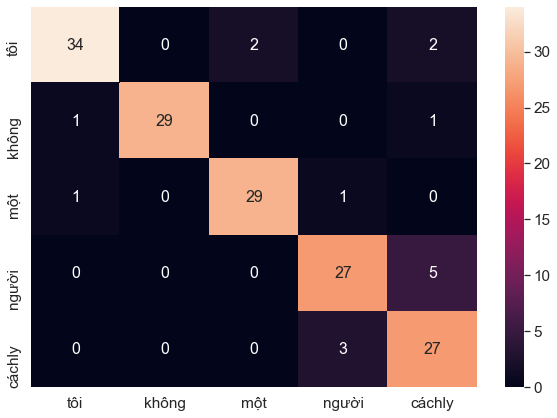

In [142]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

matrix = confusion_matrix(y_test, y_predict, labels=stt)

df_cm = pd.DataFrame(matrix, stt, stt)
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()